In [1]:
# Calculate vflood for HGM given file input
import geopandas as gpd
import os
import rasterio
from rasterio.mask import mask
from shapely.geometry import shape
from rasterio.plot import show
import numpy as np

In [3]:
savefile = 'exampleprojects'

workspace = r'D:\gis\projects\YazooHGM\exampleprojects'
foi = os.path.join(workspace, 'examples.shp')


foi = gpd.read_file(foi).to_crs(5070)
foi['uid'] = foi.index.map(hash)

pv = os.path.join(workspace, 'Yazoo_PNV.shp')
pv = gpd.read_file(pv).to_crs(5070)

flood2 = os.path.join(workspace, 'alt2_2year.tif')
flood5 = os.path.join(workspace, 'alt2_2year.tif.tif')

In [16]:
flood = rasterio.open(flood2)
flood, flood_transform =rasterio.mask.mask(flood, foi.dissolve().geometry, crop=True)

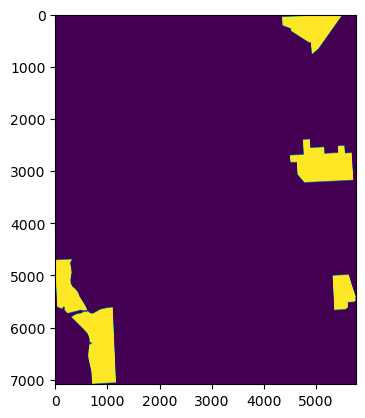

<Axes: >

In [17]:
show(flood)

In [19]:
shapes = rasterio.features.shapes(flood[0], transform=flood_transform, mask=flood[0]==1)
geoms = []
values = []

for geom,value in shapes:
    geoms.append(shape(geom))
    values.append(value)
# Create a GeoDataFrame from the vector polygons
#gdf_vector = gpd.GeoDataFrame({'geometry': [shape(geom) for geom, value in shapes]})
flood_vector = gpd.GeoDataFrame({'geometry': geoms, 'value': values})
flood_vector = flood_vector.set_crs(5070)

In [41]:
foipv = gpd.overlay(foi, pv, how='intersection')

In [42]:
foipv['veg']=foipv['HGM'].str.split('-', expand=True)[0]

In [43]:
foipv = foipv.dissolve(by=['uid', 'veg'])

In [44]:
#foiflood = gpd.sjoin(foipv, flood_vector, how='left', predicate='intersects')
foiflood = gpd.overlay(foipv, flood_vector, how='intersection')

In [45]:
#['flats', 'backwater', 'overbank', 'isolated', 'connected']
foiflood['vegtype'] = np.select(
    [
        foiflood['HGM'].str.contains('F-'), 
        foiflood['HGM'].str.contains('RB'),
        foiflood['HGM'].str.contains('RO'),
        foiflood['HGM'].str.contains('D-3'),
        foiflood['HGM'].str.contains('D-4'),
        foiflood['HGM'].str.contains('D-1'),
        foiflood['HGM'].str.contains('D-2')
    ], 
    ['flats', 'backwater', 'overbank','isolated', 'isolated', 'connected', 'connected'], 
    default='Unknown'
)

In [47]:
foiflood = foiflood.dissolve(by=['Name', 'vegtype'], aggfunc={'value':'mean'})
foiflood = foiflood.reset_index()
foiflood = foiflood[foiflood['vegtype']!='Unknown']

In [48]:
foiflood

,Name,vegtype,geometry,value
0,HGM example 1,backwater,MULTIPOLYGON Z (((481862.926 1076808.525 0.000...,1.0
1,HGM example 1,flats,"POLYGON Z ((480221.647 1078235.383 0.000, 4802...",1.0
2,HGM example 1,isolated,"POLYGON Z ((480656.799 1077857.039 0.000, 4806...",1.0
4,HGM example 2,backwater,MULTIPOLYGON Z (((483415.909 1071063.034 0.000...,1.0
5,HGM example 2,isolated,MULTIPOLYGON Z (((484032.000 1069235.548 0.000...,1.0
6,HGM example 3,backwater,MULTIPOLYGON Z (((483985.771 1061699.559 0.000...,1.0
7,HGM example 3,overbank,MULTIPOLYGON Z (((483722.340 1061666.031 0.000...,1.0
8,HGM example 4,backwater,MULTIPOLYGON Z (((468168.234 1062681.017 0.000...,1.0
9,HGM example 4,flats,MULTIPOLYGON Z (((468064.602 1062726.737 0.000...,1.0
10,HGM example 4,isolated,MULTIPOLYGON Z (((467765.256 1064452.088 0.000...,1.0


In [50]:
'''
import folium
m = foi.explore()
#woodypoly.explore(m=m, color='yellow')
foiflood.explore(m=m, color='purple')
folium.LayerControl().add_to(m) 
m
'''

"\nimport folium\nm = foi.explore()\n#woodypoly.explore(m=m, color='yellow')\nfoiflood.explore(m=m, color='purple')\nfolium.LayerControl().add_to(m) \nm\n"

In [12]:
foiflood = foiflood.rename(columns={'value':'vfreq'})
foiflood.to_parquet(os.path.join(workspace,savefile + '_vfreq.parquet'))